In [66]:
import astropy.units as u
from astropy.io import fits
from astropy.nddata import CCDData, Cutout2D
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from reproject import reproject_interp,reproject_adaptive
import os

In [45]:
# HST PSF from STSci website
# oversample factor: 4
psf_f555w = fits.open('SH0ES_N5584/PSFSTD_WFC3UV_F555W.fits',
                      ignore_missing_end=True)[0].data.mean(axis=0)
psf_f814w = fits.open('SH0ES_N5584/PSFSTD_WFC3UV_F814W.fits',
                      ignore_missing_end=True)[0].data.mean(axis=0)
psf_f160w = fits.open('SH0ES_N5584/PSFSTD_WFC3IR_F160W.fits',
                      ignore_missing_end=True)[0].data.mean(axis=0)

# JWST PSF generated with WebbPSF
# oversample factor: 4
psf_f090w = fits.open('SH0ES_N5584/F090W_PSF.fits')[0].data
psf_f150w = fits.open('SH0ES_N5584/F150W_PSF.fits')[0].data
psf_f277w = fits.open('SH0ES_N5584/F277W_PSF.fits')[0].data

# pixel scales
pixel_scales = {
    'f555w': 0.039 * u.arcsec,
    'f814w': 0.039 * u.arcsec,
    'f160w': 0.130 * u.arcsec,
    'f090w': 0.031 * u.arcsec,
    'f150w': 0.031 * u.arcsec,
    'f277w': 0.063 * u.arcsec
}

???????????????????????????????????????????????????????????????????????????????? [astropy.io.fits.card]


In [84]:
# select filter to reproject
original_psf = psf_f277w
original_pixel_scale = pixel_scales['f277w'] 
new_pixel_scale = 0.03 * u.arcsec

# original WCS
wcs = WCS(naxis=2)
wcs.wcs.crpix = [original_psf.shape[0]/2, original_psf.shape[1]/2]
wcs.wcs.crval = [0,0]
wcs.wcs.cdelt = np.array([-original_pixel_scale.to(u.deg).value, 
                          original_pixel_scale.to(u.deg).value])
wcs.wcs.ctype = ["RA---TAN", "DEC--TAN"]

# new WCS
new_shape = (int(original_psf.shape[0] * original_pixel_scale/new_pixel_scale),
             int(original_psf.shape[1] * original_pixel_scale/new_pixel_scale))
wcs_new = WCS(naxis=2)
wcs_new.wcs.crpix = [new_shape[0]/2, new_shape[1]/2]
wcs_new.wcs.crval = [0,0]
wcs_new.wcs.cdelt = np.array([-new_pixel_scale.to(u.deg).value, new_pixel_scale.to(u.deg).value])
wcs_new.wcs.ctype = ["RA---TAN", "DEC--TAN"]



(<matplotlib.colors.LogNorm at 0x16b430750>, 0)

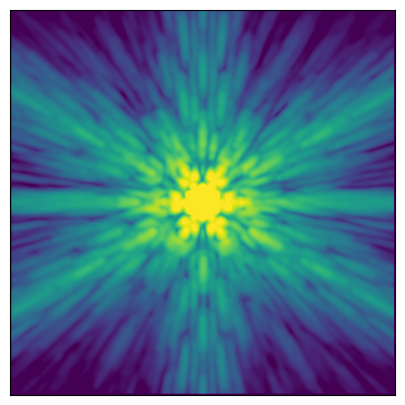

In [85]:
array, footprint = reproject_adaptive((original_psf,wcs), 
                                        output_projection = wcs_new,
                                        shape_out=new_shape,
                                        conserve_flux=True)
array[array<=0] = 0
array[~np.isfinite(array)] = 0

astroplot(array, percentiles=[5,99])

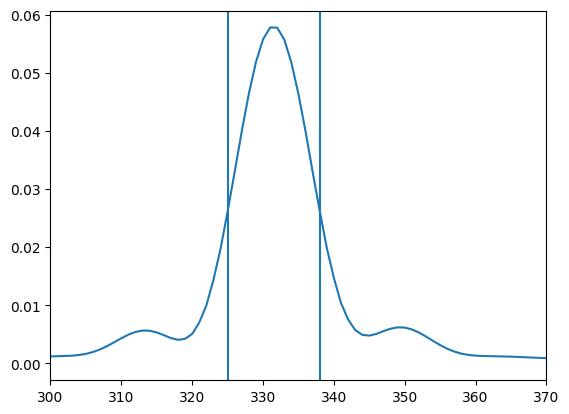

In [89]:
plt.plot(array.sum(axis=0))
plt.xlim(300,370)
plt.axvline(325)
plt.axvline(338)

In [86]:
folder = 'SH0ES_N5584_reprojected_iter2'
filename = 'F277W_PSF_0.03as_Oversample4x.npy'
np.save(os.path.join(folder,filename), array)